In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import sys
sys.path.append("..")

In [18]:
import os
import glob
from tqdm import tqdm

import numpy as np
import cv2

import torch
from torch.autograd import Variable as V
from torchvision import transforms as trn
from feature_extraction.resnet import load_resnet

def get_video_from_mp4(file, sampling_rate):
    cap = cv2.VideoCapture(file)
    frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    buf = np.empty((int(frameCount / sampling_rate), frameHeight,
                   frameWidth, 3), np.dtype('uint8'))
    fc = 0
    ret = True
    while fc < frameCount and ret:
        fc += 1
        (ret, frame) = cap.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        if fc % sampling_rate == 0:
            buf[int((fc - 1) / sampling_rate)] = frame
            break

#     while fc < frameCount and ret:
#         fc += 1
#         if fc % sampling_rate == 0:
#             (ret, buf[int((fc - 1) / sampling_rate)]) = cap.read()

    cap.release()
    return np.expand_dims(buf, axis=0)[0], 1


def get_predictions(model, video_list, sampling_rate=4):
    centre_crop = trn.Compose([
                trn.ToPILImage(),
                trn.Resize((224,224)),
                trn.ToTensor(),
                trn.Normalize([0.485, 0.456, 0.406],
                              [0.229, 0.224, 0.225])])
    all_preds = []
    for video_file in tqdm(video_list):
        #print(video_file)
        vid, num_frames = get_video_from_mp4(video_file, sampling_rate)
        video_file_name = os.path.split(video_file)[-1].split(".")[0]

        for frame in range(num_frames):
            img =  vid[0,:,:,:]
            input_img = V(centre_crop(img).unsqueeze(0))
            if torch.cuda.is_available():
                input_img = input_img.cuda()

            preds = model.forward(input_img)[-1]
            topk=(1,5)
            _, pred = preds.topk(max(topk), dim=1, largest=True, sorted=True)
            all_preds.append(pred.cpu().numpy())
    return np.concatenate(all_preds, axis=0)


In [19]:
video_dir = '../data/AlgonautsVideos268_All_30fpsmax/'
video_list = glob.glob(video_dir + '/*.mp4')
video_list.sort()
model = load_resnet("resnet50")
pred = get_predictions(model, video_list, sampling_rate=4)

100%|██████████| 1102/1102 [04:23<00:00,  4.17it/s]


In [58]:
pred_train = pred[:1000, :1]
pred_test = pred[1000:, :1]

In [17]:
file = open('imagenet_labels.txt', "r")
import ast
contents = file.read()
dictionary = ast.literal_eval(contents)

file.close()

dictionary[97]

'drake'

In [84]:
values, counts = np.unique(pred_train, return_counts=True)
ind = np.argpartition(-counts, kth=10)[:10]

perc_train = counts[ind]/10
labels_train = [dictionary[i][:8] for i in values[ind]]

values, counts = np.unique(pred_test, return_counts=True)
ind = np.argpartition(-counts, kth=10)[:10]

perc_test = counts[ind]/1.2
labels_test = [dictionary[i][:8] for i in values[ind]]

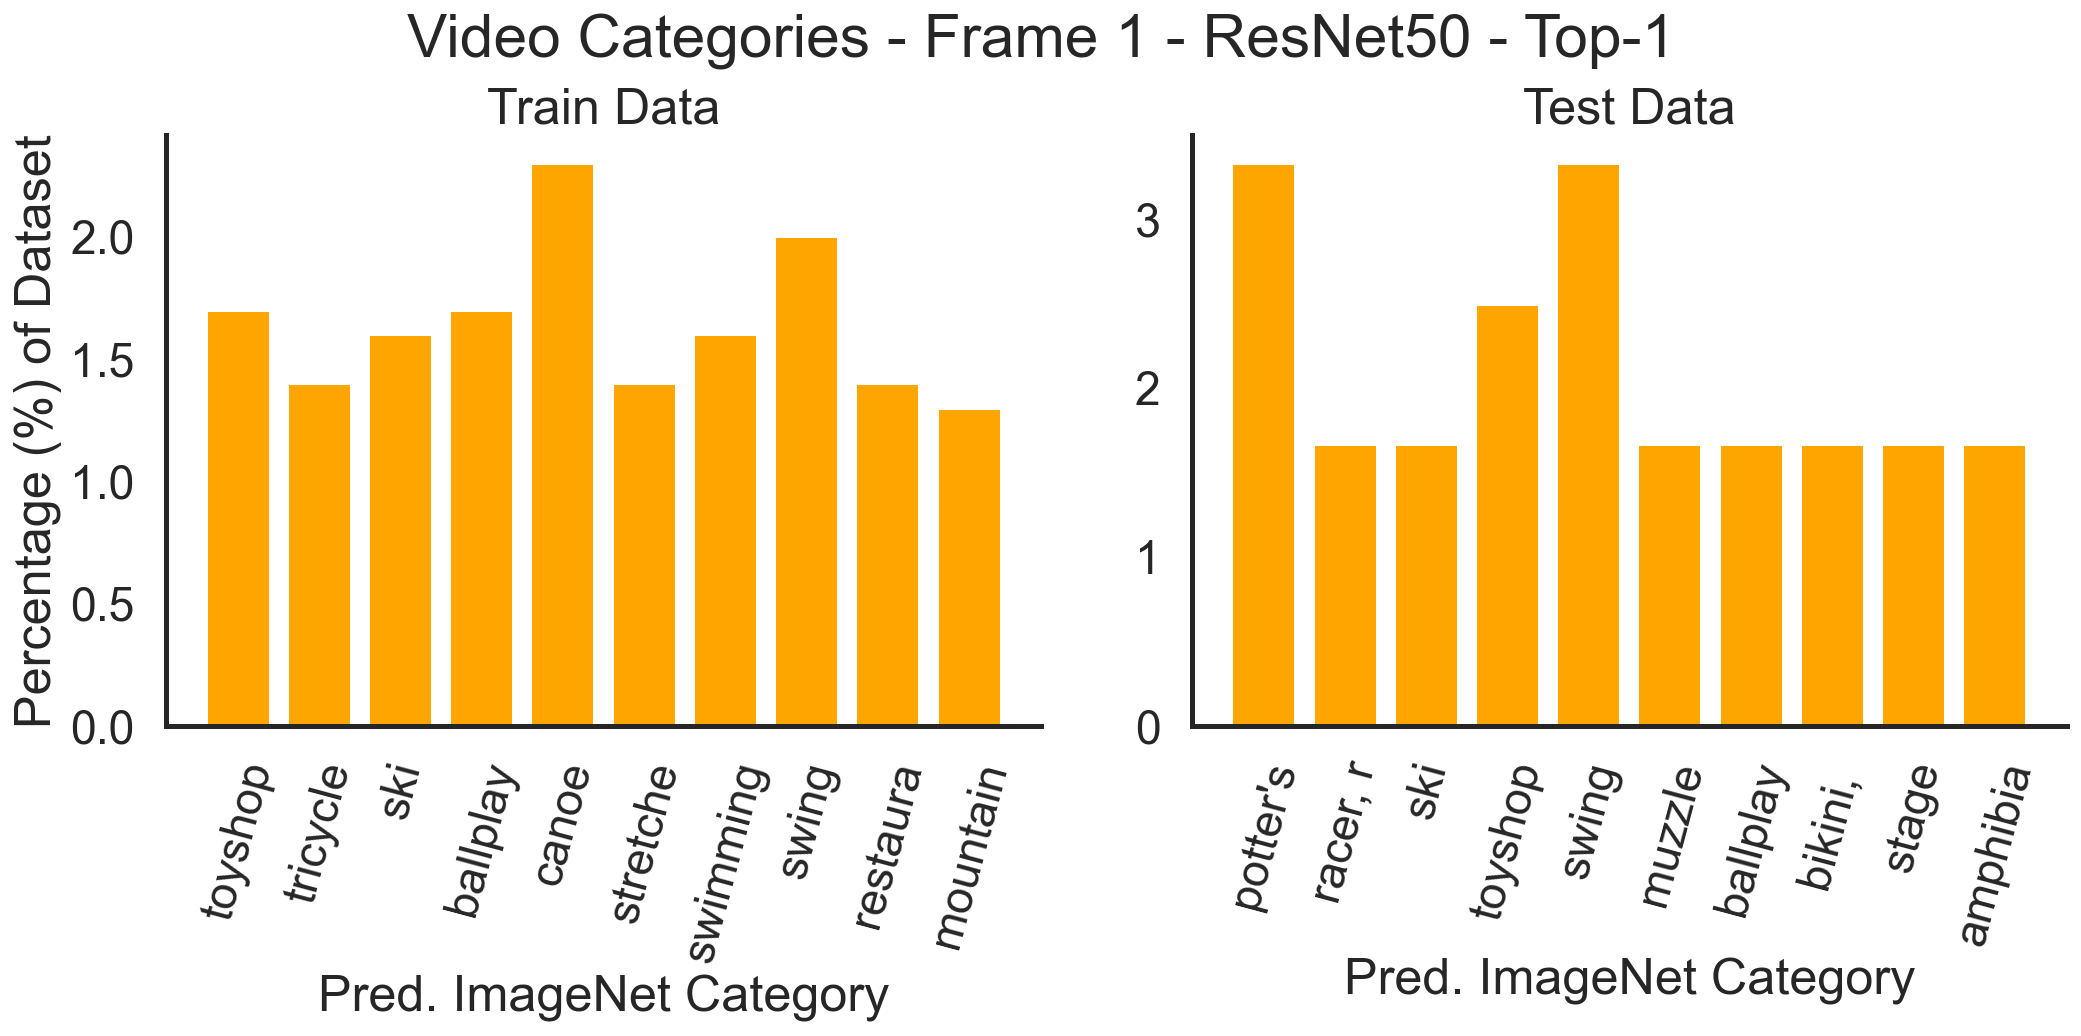

In [108]:
from mle_toolbox import visualize
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
fig.subplots_adjust(top=0.99)

axs[0].bar(np.arange(10), perc_train, color="orange")
axs[0].set_xticks(np.arange(10))
axs[0].set_xticklabels(labels_train, rotation=75)

axs[1].bar(np.arange(10), perc_test, color="orange")
axs[1].set_xticks(np.arange(10))
axs[1].set_xticklabels(labels_test, rotation=75)

for i in range(2):
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].set_xlabel("Pred. ImageNet Category")
axs[0].set_ylabel("Percentage (%) of Dataset")
axs[0].set_title("Train Data")
axs[1].set_title("Test Data")

fig.suptitle("Video Categories - Frame 1 - ResNet50 - Top-1", y=0.92)

fig.tight_layout()